In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.join('/Users/cd8607/Documents/Lammps_MD/', 'git_folder', 'Classes'))
import He_Fitting_Serial
import Handle_PotFiles_He
import time
import glob
from scipy.optimize import minimize
os.chdir('/Users/cd8607/Documents/Lammps_MD')
from scipy.integrate import simpson

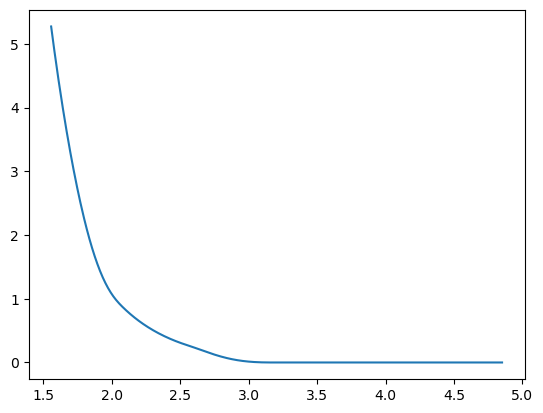

In [18]:
pot, potlines, pot_params = Handle_PotFiles_He.read_pot('git_folder/Potentials/beck.eam.he')

n_knots = {}
n_knots['He F'] = 0
n_knots['H-He p'] = 0
n_knots['He-W p'] = 2
n_knots['He-H p'] = 0
n_knots['He-He p'] = 0
n_knots['W-He'] = 4
n_knots['He-He'] = 0
n_knots['H-He'] = 0

beck = He_Fitting_Serial.Fit_EAM_Potential(pot, n_knots, pot_params, potlines, None, 0, '')

whe = beck.pot_lammps['W-He'][1:]

r = np.linspace(0, beck.pot_params['rc'], beck.pot_params['Nr'])[1:]

phi = whe/r

plt.plot(r[400:], phi[400:])

pairwise_ref = np.column_stack([r[400:], phi[400:]])

In [19]:
def loss_he_he(x, eam_fit):

    # vac = np.array([2.72123368, 3.14221])
    
    a = 5.5

    vac = 4.7
    tet = 6.16
    oct = 6.4
    
    r = np.array([1.75654879, 2.83234982, 3.59985379, 2.72123368, 3.14221, 1.571125, 2.221878, 3.51309758, 3.84840558])
    loss = 0

    coef_dict = eam_fit.fit_sample(x)

    ZBL = He_Fitting_Serial.ZBL(74, 2)

    poly = He_Fitting_Serial.splineval(pairwise_ref[:, 0], coef_dict['W-He'], eam_fit.knot_pts['W-He'])

    zbl = ZBL.eval_zbl(pairwise_ref[:, 0])

    phi_pot = poly + zbl
    
    tet_eam = 4*phi_pot[0] + 4*phi_pot[1] + 8*phi_pot[2] + a * 1.2812

    vac_eam = 8*phi_pot[3] + 6*phi_pot[4] + a * 1.076

    oct_eam = 2* phi_pot[5] + 4*phi_pot[6] + 8*phi_pot[7] + 8*phi_pot[8] + a *1.32
    
    loss += (vac - vac_eam)**2 + (tet - tet_eam)**2 + (oct - oct_eam)**2

    loss += np.linalg.norm(coef_dict['W-He'])

    return loss

In [20]:
n_knots = {}
n_knots['He F'] = 0
n_knots['H-He p'] = 0
n_knots['He-W p'] = 0
n_knots['He-H p'] = 0
n_knots['He-He p'] = 0
n_knots['W-He'] = 4
n_knots['He-He'] = 0
n_knots['H-He'] = 0

eam_fit = He_Fitting_Serial.Fit_EAM_Potential(pot, n_knots, pot_params, potlines, None, 0, '')


sample = np.hstack([1, np.zeros((6,))])
res = minimize(loss_he_he, sample, args=(eam_fit), method='Powell', options={'maxfev':1e4})

print(res)

eam_fit.sample_to_file(res.x)


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 35.599488275607435
       x: [-3.672e+00  6.708e+00 -4.668e+00 -4.496e-01  5.263e-01
           -3.156e-01  0.000e+00]
     nit: 10
   direc: [[ 4.215e-03 -1.264e-01 ... -4.276e-02  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [-2.915e-04 -5.663e-03 ... -1.259e-02  0.000e+00]]
    nfev: 709


Text(0, 0.5, 'Energy / eV')

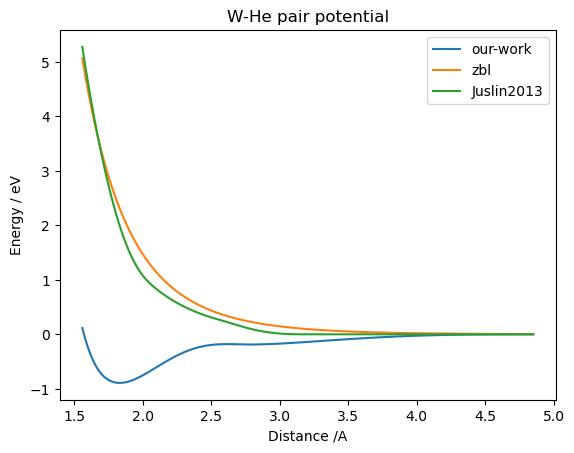

In [21]:
r = np.linspace(0, eam_fit.pot_params['rc'], eam_fit.pot_params['Nr'])[1:]

dr = eam_fit.pot_params['rc']/eam_fit.pot_params['Nr']

phi = eam_fit.pot_lammps['W-He'][1:] / r

zbl_w = He_Fitting_Serial.ZBL(74, 2)

plt.plot(r[400:], phi[400:], label='our-work')

plt.plot(r[400:], zbl_w.eval_zbl(r[400:]), label='zbl')

plt.plot(pairwise_ref[:,0], pairwise_ref[:,1], label = 'Juslin2013')

plt.legend()
plt.title('W-He pair potential')

plt.xlabel('Distance /A')
plt.ylabel('Energy / eV')

In [22]:
from scipy.spatial import cKDTree

def create_bcc_lattice(unit_cells):
    # Basis atoms for a BCC unit cell
    basis = np.array([
        [0, 0, 0],
        [0.5, 0.5, 0.5]
    ])
    
    # Initialize list to hold lattice points
    lattice_points = []
    
    # Iterate over each unit cell in the 3D grid
    for i in range(unit_cells):
        for j in range(unit_cells):
            for k in range(unit_cells):
                # Offset for the current unit cell
                offset = np.array([i, j, k])
                for atom in basis:
                    # Calculate and store the lattice point
                    lattice_points.append(atom + offset)
    
    # Convert to NumPy array for convenience
    lattice_points = np.array(lattice_points)
    return lattice_points


# Number of unit cells in each direction
unit_cells = 4

# Create the BCC lattice
bcc_lattice = create_bcc_lattice(unit_cells)

bcc_lattice = np.row_stack([bcc_lattice, np.array([0.5,0.5,0])])
kdtree = cKDTree(bcc_lattice, boxsize=unit_cells)

3.14221*kdtree.query(bcc_lattice[-1], 25)[0]


array([0.        , 1.571105  , 1.571105  , 2.221878  , 2.221878  ,
       2.221878  , 2.221878  , 3.51309758, 3.51309758, 3.51309758,
       3.51309758, 3.51309758, 3.51309758, 3.51309758, 3.51309758,
       3.84840558, 3.84840558, 3.84840558, 3.84840558, 3.84840558,
       3.84840558, 3.84840558, 3.84840558, 4.713315  , 4.713315  ])

In [23]:
def loss_w_he_lj(x, eam_fit, ref):

    loss = 0

    coef_dict = eam_fit.fit_sample(x)

    ZBL = He_Fitting_Serial.ZBL(2, 74)

    poly = He_Fitting_Serial.splineval(ref[:, 0], coef_dict['W-He'], eam_fit.knot_pts['W-He'])

    zbl = ZBL.eval_zbl(ref[:, 0])

    phi_pot = poly + zbl
    
    loss = np.sum((phi_pot - ref[:, 1])**2, axis=0)

    # r_zbl = np.linspace(1.5, 2.25, 10)

    # loss += np.sum(EAM_Fitting_Serial.splineval(r_zbl, coef_dict['H-He'], eam_fit.knot_pts['H-He']) ** 2, axis = 0)

    return loss

n_knots = {}
n_knots['He F'] = 0
n_knots['H-He p'] = 0
n_knots['He-W p'] = 0
n_knots['He-H p'] = 0
n_knots['He-He p'] = 0
n_knots['W-He'] = 4
n_knots['He-He'] = 0
n_knots['H-He'] = 0

eam_fit = He_Fitting_Serial.Fit_EAM_Potential(pot, n_knots, pot_params, potlines, None, 0, '')

x = np.linspace(2.6, 4, 20)

y = 4 * 1e-3 * ( (2.75/x)**12 - (2.75/x)**6 )

ref = np.column_stack([x, y])

sample = np.hstack([np.zeros((6,))])

res = minimize(loss_w_he_lj, sample, args=(eam_fit, ref), method='Powell', options={'maxfev':1e4})

print(res)

eam_fit.sample_to_file(res.x)


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.5816927538847374e-06
       x: [ 0.000e+00  0.000e+00  0.000e+00 -2.606e-01  5.309e-01
           -1.008e+00]
     nit: 6
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  2.265e-03  1.947e-01]
           [ 0.000e+00  0.000e+00 ...  4.462e-01 -1.799e+00]]
    nfev: 305


In [1]:
def loss_whe_edensity(x, eam_fit, ref):

    loss = 0

    coef_dict = eam_fit.fit_sample(x)

    poly = He_Fitting_Serial.splineval(ref[:, 0], coef_dict['He-W p'], eam_fit.knot_pts['He-W p'])

    neg_exp = He_Fitting_Serial.neg_exp(ref[:, 0], x[0], x[1], x[2])

    phi_pot = poly + neg_exp
    
    loss = np.sum((phi_pot - ref[:, 1])**2, axis=0)

    # r_zbl = np.linspace(1.5, 2.25, 10)

    # loss += np.sum(EAM_Fitting_Serial.splineval(r_zbl, coef_dict['H-He'], eam_fit.knot_pts['H-He']) ** 2, axis = 0)

    return loss

n_knots = {}
n_knots['He F'] = 0
n_knots['H-He p'] = 0
n_knots['He-W p'] = 2
n_knots['He-H p'] = 0
n_knots['He-He p'] = 0
n_knots['W-He'] = 0
n_knots['He-He'] = 0
n_knots['H-He'] = 0

eam_fit = He_Fitting_Serial.Fit_EAM_Potential(pot, n_knots, pot_params, potlines, None, 0, '')

x = np.linspace(0, 5, 100)

y =  (2.952 * np.exp(-1.453*x) + 1.799 * np.exp(-2.906*x))**2

ref = np.column_stack([x, y])

sample = eam_fit.gen_rand()

print(sample)

res = minimize(loss_whe_edensity, sample, args=(eam_fit, ref), method='Powell', options={'maxfev':1e4})

print(res)

eam_fit.sample_to_file(res.x)

r = np.linspace(0, eam_fit.pot_params['rc'], eam_fit.pot_params['Nr'])

plt.plot(ref[:,0], ref[:,1])

plt.plot(r, eam_fit.pot_lammps['He-W p'])


NameError: name 'He_Fitting_Serial' is not defined